# RGI04 (Arctic Canada South)

F. Maussion

Full replace by Philipp and Frank, except Labrador which still used RGI6

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 4

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '04_rgi60_ArcticCanadaNorth.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
589,7408,40784.7,"Barrand, Burgess, Cawkwell, Copland, Filbert, ...",Bolch,2015,Randolph Glacier Inventory; Umbrella RC for me...,2000,1958,2010
745,7,103.6,"Barrand, Burgess, Cawkwell, Copland, Filbert, ...",Bolch,2021,Randolph Glacier Inventory; Umbrella RC for me...,2002,2002,2002
750,10831,40510.4,"Paul, Rastner",Paul,2022,Various (GlobGlacier),2000,1999,2002


In [5]:
sdf.loc[sdf.index == 750]

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
750,10831,40510.4,"Paul, Rastner",Paul,2022,Various (GlobGlacier),2000,1999,2002


Notes based on individual submission evaluations: 

- 589: This is the RGI6
- 745: also RGI6, corrected: for https://github.com/GLIMS-RGI/rgi7_scripts/issues/8
- 750: this is the new submission by F&P - valid above 61°N, below we need RGI6: https://github.com/GLIMS-RGI/rgi7_scripts/issues/57

In [6]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

### Apply selection criteria to create the RGI7 data subset

In [7]:
rgi7_north = shp.loc[shp['subm_id'].isin([750])].copy()
print(needs_size_filter(rgi7_north))
rgi7_north['is_rgi6'] = False

False


In [8]:
rgi7_south = shp.loc[shp['subm_id'].isin([589, 745])].copy()
rgi7_south = rgi7_south.loc[rgi7_south.CenLat < 61]
print(needs_size_filter(rgi7_south))
rgi7_south['is_rgi6'] = True

False


In [9]:
# combine the geodataframes
rgi7 = pd.concat([rgi7_north, rgi7_south])

### Some sanity checks 

In [ ]:
dupes = find_duplicates(rgi7)

In [10]:
rgi7 = correct_geoms(rgi7)

Found 91 invalid geometries out of 10934. Correcting...
After correction, 0 geometries are still invalid.
Area changed by -0.2 m2 (-0.0000%)


In [21]:
needs_size_filter(rgi7)

False

In [12]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
750,10831,10831
589,103,103


In [13]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    if np.any(np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())):
        print('Orphan rock outcrops detected.')

### Plots 

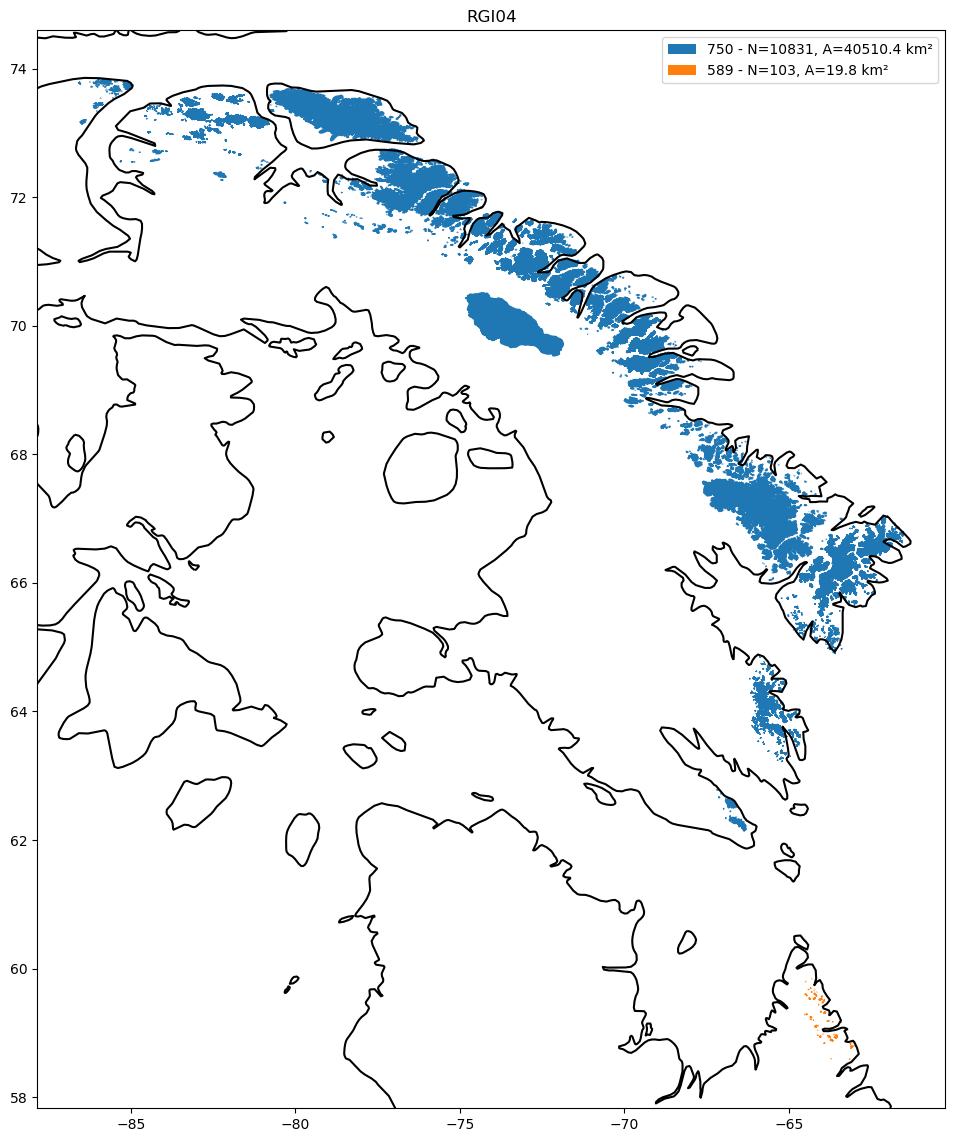

In [14]:
plot_map(rgi7, reg)

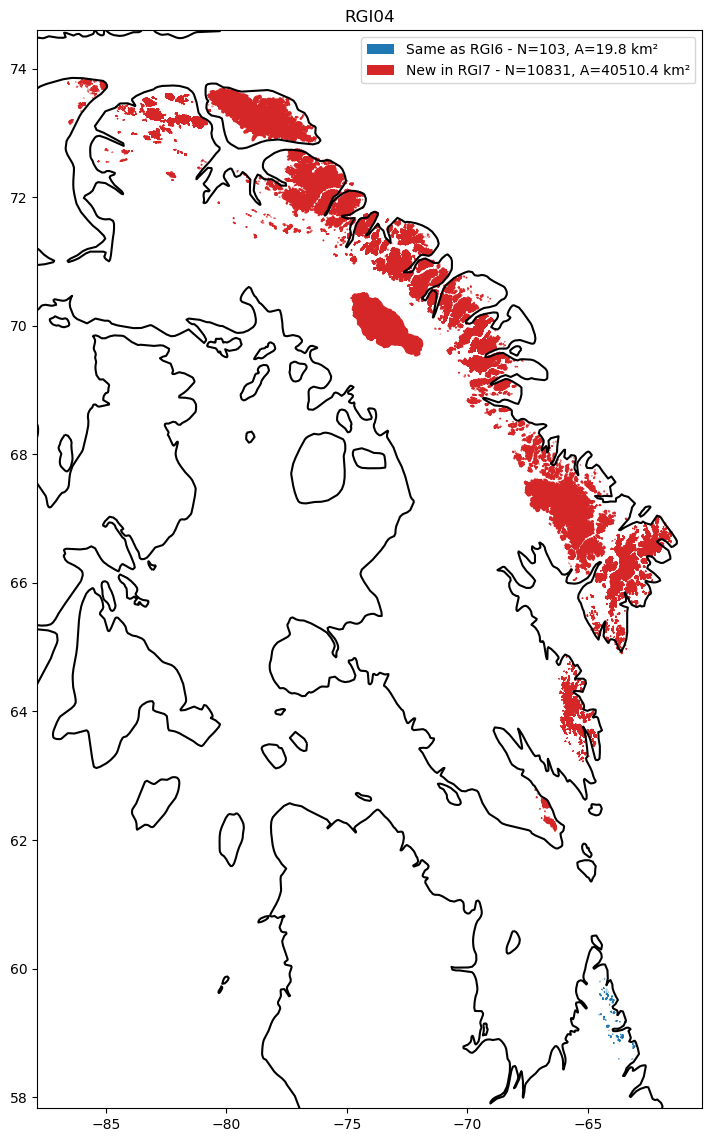

In [15]:
plot_map(rgi7, reg, is_rgi6=True)

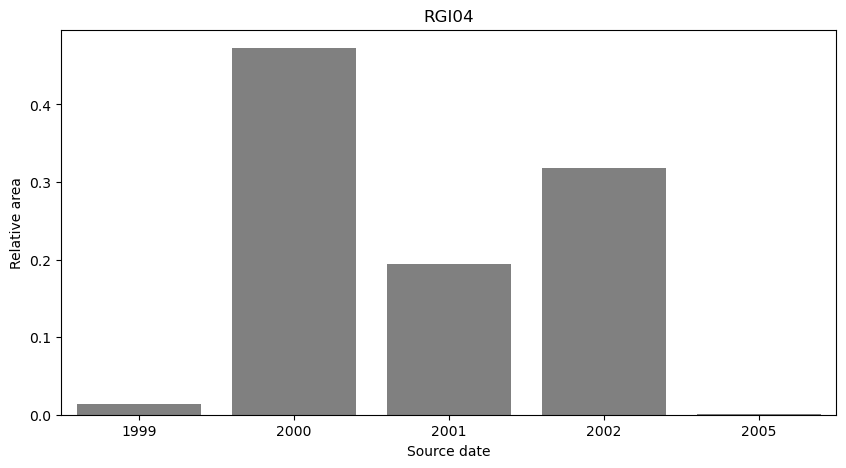

In [16]:
plot_date_hist(rgi7, reg)

### Text for github

In [17]:
fgh = sdf.T
fgh

subm_id,750,589
N,10831,103
A,40510.4,19.8
analysts,"Paul, Rastner","Barrand, Burgess, Cawkwell, Copland, Filbert, ..."
submitters,Paul,Bolch
release_date,2022,2015
geog_area,Various (GlobGlacier),Randolph Glacier Inventory; Umbrella RC for me...
src_date_mode,2000,2005
src_date_min,1999,2005
src_date_max,2002,2005


In [18]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 750                   | 589                                                                                                     |
|:--------------|:----------------------|:--------------------------------------------------------------------------------------------------------|
| N             | 10831                 | 103                                                                                                     |
| A             | 40510.4               | 19.8                                                                                                    |
| analysts      | Paul, Rastner         | Barrand, Burgess, Cawkwell, Copland, Filbert, Gardner, Hartmann, OCallaghan, Paul, Sharp, Wolken, Wyatt |
| submitters    | Paul                  | Bolch                                                                                                   |
| release_date  | 2022                  | 2015                                                                  

## Write out and tar 

In [19]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI04/
RGI04/RGI04.shx
RGI04/RGI04.prj
RGI04/RGI04.cpg
RGI04/RGI04.shp
RGI04/RGI04.dbf
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI04.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI04'], returncode=0)


## Consistency checks

### With RGI6 (South) 

In [24]:
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [19]:
rgi6 = rgi6.loc[rgi6.CenLat < 61]

In [20]:
len(rgi7_south), len(rgi6)

(103, 103)

Test the areas:

In [21]:
rgi6['Area_us'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7_south['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [22]:
print('Area RGI7a (km2)', rgi7_south['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['Area_us'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['Area_us'].sum() - rgi7_south['area'].sum()) * 1e-6)

Area RGI7a (km2) 19.794548737645385
Area RGI6 (km2) 19.795000000000005
Area RGI6 computed by us (km2) 19.79453775302491
diff areas RGI6 - RGI7 computed by us (km2) -1.0984620478004217e-05


### With F&P submission 

In [25]:
ref_pr = open_zip_shapefile(data_dir + '/l0_support_data/c3s_gi_rgi04_L7_2000_v1.zip')
ref_pr['area'] = ref_pr.to_crs({'proj':'cea'}).area 

In [27]:
print('Number of glaciers in RGI7 subset:', len(rgi7_north))
print('Number of glaciers in reference data (FP):', len(ref_pr))
print('Difference:', len(rgi7_north)-len(ref_pr))

Number of glaciers in RGI7 subset: 10831
Number of glaciers in reference data (FP): 10831
Difference: 0


In [28]:
print('Area RGI7a (km2)', rgi7_north['area'].sum() * 1e-6)
print('Area Ref (km2)', ref_pr['area'].sum())
print('diff areas Ref - RGI7 (km2)', (ref_pr['area'].sum() - rgi7_north['area'].sum()) * 1e-6)

Area RGI7a (km2) 40510.44095829107
Area Ref (km2) 40510440748.15837
diff areas Ref - RGI7 (km2) -0.00021013269805908203


### With RGI6 (Full: differences do not depict problems, just differences) 

In [29]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [30]:
len(rgi7), len(rgi6)

(10934, 7415)

Test the areas:

In [31]:
rgi6['Area_us'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [32]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['Area_us'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['Area_us'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 40530.235507028716
Area RGI6 (km2) 40888.228
Area RGI6 computed by us (km2) 40888.286666425425
diff areas RGI6 - RGI7 computed by us (km2) 358.0511593967132
